# SM Test

In [1]:
# Import Gibbs reactor data

import pandas as pd
import numpy as np
np.set_printoptions(precision=6, suppress=True)

v2 = 0 # if set to 1, ALAMOPY will fit to custom multivariable function and PySMO will fit to multivariable poly function
if v2 ==1:
    data = pd.read_excel(r'..\Core-tasks-2.5\Gibbs_surrogatesv2.xlsx')
    data.columns = ['tag','set','result','time','solution_time','err','output_graph_error',
                    'node_err_gibbs','turb_gibbs','input_gibbs_Tin','input_gibbs_Fin',
                    'output_gibbs_heat_duty','Q_SM','Q_SM_%error','Q_SM2','Q_SM2_%error',
                    'output_gibbs_H2','output_gibbs_H2O','output_gibbs_CO2','output_gibbs_CO',
                    'output_gibbs_N2','output_gibbs_Tout','output_gibbs_Fout','Fout_SM','mol_F_sum']
    x1input = data.input_gibbs_Fin
    x2input = data.input_gibbs_Tin
    xinput = pd.concat([x1input,x2input],axis=1)
    zoutput = data.output_gibbs_heat_duty
else: # otherwise, ALAMOPY and PySMO will both fit to 3rd order poly functions
    data = pd.read_excel(r'..\Core-tasks-2.5\Gibbs_reactor_surrogates.xlsx')
    data.columns = ['tag','set','result','time','solution_time','err','output_graph_error',
                          'node_err_gibbs','turb_gibbs','input_gibbs_Tin','input_gibbs_Fin',
                           'output_gibbs_heat_duty','output_gibbs_H2','H2_SM','output_gibbs_H2O',
                          'H2O_SM','output_gibbs_CO2','CO2_SM','output_gibbs_CO','CO_SM',
                          'output_gibbs_N2','N2_SM','output_gibbs_Tout','Tout_SM']
    xinput = data.input_gibbs_Tin
    zoutput = data.output_gibbs_H2

#    print(data) # takes up a lot of space if uncommented
x = np.array(xinput)
z = np.array(zoutput)
print('xdata saved') # check that the input array was constructed correctly
print(x)

xdata saved
[455.167495 542.922493 402.441282 594.515916 583.249014 472.171873
 580.81366  429.030996 471.950256 584.782015 534.227068 457.419509
 544.631616 597.09826  476.072102 410.063655 528.067143 426.405401
 490.68621  440.67404  579.415001 433.00729  566.052401 524.953247
 549.159396 486.211196 404.952822 409.029795 505.363452 555.263832
 431.690536 434.090532 518.323796 526.29058  586.367698 551.532478
 469.940992 485.344657 553.102761 458.636081 451.17492  425.847721
 474.333033 494.140585 460.591719 517.354206 415.437731 592.803706
 445.728079 540.077633 447.443748 509.481944 418.711313 507.987936
 511.383683 539.477234 438.930289 478.165333 571.456003 572.317721
 598.605333 437.982122 499.916491 488.239232 514.582892 423.914634
 574.869642 513.54586  565.544642 417.079854 501.560053 482.124429
 448.329323 521.271411 467.638428 523.826151 533.457928 547.937899
 589.922318 463.233508 453.658155 502.056256 531.847877 591.564552
 537.408469 413.365693 480.097803 557.950316 497.3

In [2]:
# Train Gibbs reactor data with TensorFlow/Keras

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam as opt
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import PolynomialFeatures

# rescale data to avoid potential training issues
trX = x/max(x)
trY = z/max(z)

n = 3 # seeking 3rd order polynomial
trX_expanded = np.expand_dims(trX, axis=1)
poly = PolynomialFeatures(n)
trX_expanded = poly.fit_transform(trX_expanded)

inp = Input((n+1)) # 4 features, x^3 x^2 x constant
out = Dense(1)(inp)
model = Model(inputs=inp, outputs=out)
model.compile(optimizer=opt(learning_rate=1e-3), loss="mean_squared_error")
#print(trX)
#print(trX_expanded)
trials = 500

c1 = []
c2 = []
c3 = []
c4 = []
c_list = []
increment = 25
print('Starting trials, printing every', increment, ' trials:')
for i in range(0,trials):
    if ((i+1) % increment == 0):
        print('Training trial number ', i+1)
    model.fit(trX_expanded, trY, epochs=500, verbose=0)
    c_list = opt.get_weights(model)[0]
    c1.append(c_list[0])
    c2.append(c_list[1])
    c3.append(c_list[2])
    c4.append(c_list[3])

c_scaled = [np.average(c1), np.average(c2), np.average(c3), np.average(c4)]

c = [c_scaled[j]*max(z)/((max(x))**(len(c_scaled)-1-j)) for j in range(0,len(c_scaled))]

print(np.shape(c))

Starting trials, printing every 25  trials:
Training trial number  25
Training trial number  50
Training trial number  75
Training trial number  100
Training trial number  125
Training trial number  150
Training trial number  175
Training trial number  200
Training trial number  225
Training trial number  250
Training trial number  275
Training trial number  300
Training trial number  325
Training trial number  350
Training trial number  375
Training trial number  400
Training trial number  425
Training trial number  450
Training trial number  475
Training trial number  500
(4,)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
None
The RMSE is  0.0

Coefficient values:
Scaled: [0.5288213, -0.37146467, 0.91121274, -0.49624035]
Actual: [8.451125881370531e-10, -3.5535606769156233e-07, 0.0005218030188106224, -0.17010593134018467]


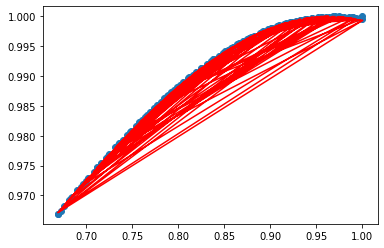

In [3]:
# TensorFlow/Keras results

import matplotlib.pyplot as plt

print(model.summary())
rsme = RootMeanSquaredError()
print('The RMSE is ', rsme.result().numpy())
print()

print('Coefficient values:')
print('Scaled:',c_scaled)
print('Actual:',c)

fig, ax = plt.subplots()
ax.scatter(trX, trY)
ax.plot(trX, model.predict(trX_expanded), color = "red")

In [4]:
# Train Gibbs reactor data with ALAMOPY

from idaes.surrogate import alamopy
if v2 == 1:
    result = alamopy.doalamo(x,z,almname='Gibbs2var',multi2power=(1),ratiopower=(1),linfcns=0,constant=0,expandoutput=True)
    print('ok')
else:
    result = alamopy.doalamo(x,z,almname='Gibbs1var',xmin=(400),xmax=(600),monomialpower=(2,3),expandoutput=True)
#alamopy.almconfidence(result)

f = open('Gibbs.lst','r')
statistics = f.read()
print(statistics)
f.close()

FileNotFoundError: [Errno 2] No such file or directory: 'Gibbs.lst'

In [ ]:
# ALAMOPY results

print('See end of output above for calculation statistics')
print('Model: {}'.format(result['model']))
#print('Confidence Intervals : {}'.format(conf_inv['conf_inv']))
alamopy.almplot(result)

In [ ]:
# Train Gibbs reactor data with PySMO

from idaes.surrogate.pysmo.polynomial_regression import PolynomialRegression

xy_data = pd.concat([xinput,zoutput],axis=1)
print(xy_data)
print(type(xy_data))

poly_class = PolynomialRegression(original_data_input=xy_data, regression_data_input=xy_data, maximum_polynomial_order=3,
                                  multinomials=1, training_split=0.8, number_of_crossvalidations=10, overwrite=True)
features = poly_class.get_feature_vector()
poly_fit = poly_class.training()


In [ ]:
# PySMO Results

print('See end of output above for calculation statistics')

list_vars = []
for i in features.keys():
    list_vars.append(features[i])

print(poly_fit.generate_expression(list_vars))
poly_fit.parity_residual_plots()
conf_int = PolynomialRegression.confint_regression(poly_fit, confidence=0.95)

In [ ]:
# Comparing the two model equations; note, they won't match for multivariable since the ALAMOPY form is different

print('Keras gave the following fit:')
print('z = ', c[0], 'x^3 + ', c[1], 'x^2 + ', c[2], 'x + ', c[3])
print()

print('ALAMOPY gave the following fit:')
print('Model: {}'.format(result['model']))
print()

print('PySMO gave the following fit:')
print(poly_fit.generate_expression(list_vars))